In [12]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk.stem.porter import PorterStemmer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk import bigrams
from nltk.tokenize import word_tokenize
import re
import pandas as pd
import os
import json

# Load Spacy English Model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abiga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Segmentation in sentences and tokens and vocabulary
def sentence_segmentation(spacy_text):
    list_of_sentences = []
    for s in spacy_text.sents:
        list_of_sentences.append(s)
    return list_of_sentences

def tokens_segmentation(spacy_text):
    list_of_tokens = []
    for tok in spacy_text:
        list_of_tokens.append(str(tok))
    return list_of_tokens


def lowercase_and_punctuation_remover(spacy_list):
    translator = str.maketrans('', '', string.punctuation) #with string.punctuation being the list of punctuation signs
    return [tok.translate(translator) for tok in [str(tok).lower() for tok in spacy_list]]


def remove_stopwords(spacy_list):
    #print(stopwords.words('english')[:100])
    stopwords_list = stopwords.words('english')
    spacy_list_clean = []
    for token in spacy_list:
        if token not in stopwords_list :
            spacy_list_clean.append(token)
    return spacy_list_clean

def remove_empty_spaces(token_list):
    # Strip each token in the list and remove it if it's empty after stripping
    return [token.strip() for token in token_list if token.strip()]

def stemming(tokens_list):
    # Create a stemmer instance
    porter = PorterStemmer()
    # Apply the stemmer and collect the stems
    porterlemmas = []
    for word in tokens_list:
        porterlemmas.append(porter.stem(word))
    return porterlemmas

def text_data_tok_sent(df):
    
    df['sentences'] = df['text'].apply(lambda x: lowercase_and_punctuation_remover(sentence_segmentation(nlp(x))))
                                         
    df['tokens'] = df['sentences'].apply(lambda x: stemming(remove_empty_spaces(remove_stopwords(tokens_segmentation(nlp(' '.join(x)))))))
                                         
    return df 

def frequency_and_wordcloud(df):
    categories = df['category'].unique()
    results = {}
    
    for category in categories:
        print(f"50 most frequent words and wordcloud for {category}:")
        tokens_list = [item for sublist in df[df['category'] == category]['tokens'] for item in sublist]
        frequency_dist=nltk.FreqDist(tokens_list)
        frequency_dist.plot(50)
        #Create and generate a word cloud image:
        wordcloud = WordCloud().generate(" ".join(tokens_list))
        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
def data_analysis(df): 
    df = text_data_tok_sent(df)
    frequency_and_wordcloud(df)
    return df
    


In [3]:
def sentences(df):
    
    # Sentence segmentation and count
    df['sentence_count'] = df['sentences'].apply(lambda x: len(x))

    # min, max, and mean sentence counts by category
    stats_df = df.groupby('category')['sentence_count'].agg(['min', 'max', 'mean'])

    # print statistics
    print(stats_df)
    
    # visualization
    categories = df['category'].unique()
    fig, ax = plt.subplots(1, len(categories)+1, figsize=(12, 6))
    counter = 0 #to keep track of the number of a categorie for subplot index
    for category in categories:
        #print(df[df["category"] == category])
        sns.histplot(df[df["category"] == category], x = 'sentence_count', ax=ax[counter])

        # set titles for each subplot for clarity
        ax[counter].set_title(f'Sentences length frequency for {category}')
        ax[counter].axvline(stats_df.loc[category, 'mean'], color='r', linestyle='--', linewidth=2, label=f'Mean: {stats_df.loc[category, "mean"]:.2f}')
        counter += 1
    
    sns.boxplot(data=df, x='category', y='sentence_count', ax=ax[counter])
    ax[counter].set_title('Boxplot')
    plt.show()

In [4]:
#bigrams

def generate_bigrams(sentences_list):
        all_bigrams = []
        for sent in sentences_list:
            # bigrams from the list of sentences
            tokens = word_tokenize(sent)
            all_bigrams.append(list(bigrams(tokens))) #list of list of bigrams (one per sentence)
        return all_bigrams


def get_bigrams_list(df):
    df['bigrams'] = df['sentences'].apply(generate_bigrams)
    return df
    
def total_bigram_occ(df):
    pers_bigrams = {}
    sent_bigrams = {}
    all_bigrams = {}
    
    categories = df['category'].unique()
    for category in categories:
        pers_bigrams[category] = [x for x in df[df["category"] == category]['bigrams']]
        sent_bigrams[category] = sum(pers_bigrams[category], [])
        all_bigrams[category] = sum(sent_bigrams[category], [])
        print(f"For the category {category}:")
        print(f"  there are {len(all_bigrams[category])} bigrams in total and {len(set(all_bigrams[category]))} unique bigrams")
        print(f"  the minimum number of bigrams in a sentence is {min([len(s) for s in sent_bigrams[category]])}")
        print(f"  the maximum number of bigrams in a sentence is {max([len(s) for s in sent_bigrams[category]])}")
        print(f"  the average number of bigrams in a sentence is {sum([len(s) for s in sent_bigrams[category]])/len(sent_bigrams[category])}")


Graphs

In [5]:

def retrieve_json(path):
    json_string = open(path)
    
    graph = json.load(json_string)
    return graph

def extract_after_last_slash(text): 
    # for facts, regex to find the part after the last slash (to keep only the fact and not the url)
    match = re.search(r'[^/]+$', text)
    if match:
        return match.group(0)
    return None

def most_freq_properties_and_cloud(json_str):
    properties_per_category = {}
    properties_per_category_clean = {}

    for category, items in json_str.items():
        properties_per_category[category] = []
        properties_per_category_clean[category] = []

        for item in items:
            # extract all 'p' values from the bindings
            bindings = item['results']['bindings']
            for binding in bindings:
                property_value = binding['p']['value']
                #append property
                properties_per_category[category].append(property_value)
                properties_per_category_clean[category] = [extract_after_last_slash(prop) for prop in properties_per_category[category]]

        print(f"50 most frequent properties and wordcloud of properties for {category}:")
        frequency_dist_dist=nltk.FreqDist(properties_per_category_clean[category])
        frequency_dist_dist.plot(50)
        #Create and generate a word cloud image:
        wordcloud_prop = WordCloud().generate(" ".join(properties_per_category_clean[category]))
        # Display the generated image:
        plt.imshow(wordcloud_prop, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
    #print(properties_per_category['Journalists'])

#Facts: Min/max/avg number of facts per category together. Histograms and box plots for number of facts per graph for each category
def facts_graphs(json_str):
    facts = {'category' : [], 'number_facts' : []}

    for category, items in json_str.items():
        for item in items:
            bindings = item['results']['bindings']
            facts['category'].append(category)
            facts['number_facts'].append(len(bindings))
            
    df_graphs = pd.DataFrame(facts)
    
    # min, max, and mean number of facts per person by category
    stats_df_graphs = df_graphs.groupby('category')['number_facts'].agg(['min', 'max', 'mean'])

    # print statistics
    print(stats_df_graphs)
    
    # visualization
    categories = df_graphs['category'].unique()
    fig, ax = plt.subplots(1, len(categories)+1, figsize=(12, 6))
    counter = 0 #to keep track of the number of a categorie for subplot index
    for category in categories:
        #print(df_graphs[df_graphs["category"] == category])
        sns.histplot(df_graphs[df_graphs["category"] == category], x = 'number_facts', ax=ax[counter])

        # set titles for each subplot for clarity
        ax[counter].set_title(f'Number of facts by person for {category}')
        ax[counter].axvline(stats_df_graphs.loc[category, 'mean'], color='r', linestyle='--', linewidth=2, label=f'Mean: {stats_df_graphs.loc[category, "mean"]:.2f}')
        counter += 1
    
    sns.boxplot(data=df_graphs, x='category', y='number_facts', ax=ax[counter])
    ax[counter].set_title('Boxplot')
    plt.show()
    #print(facts)
                

In [6]:
df = df_lu = pd.read_csv('biographies_dataframe.csv')
df.head()


,text,category,person
0,"John Everett Benson (born 1939 - died June 8, ...",Sculptors,JohnBenson(artisan)
1,George Lilanga (1934 – 27 June 2005) was a Tan...,Sculptors,GeorgeLilanga
2,"Eric Gill works at the Midland Hotel, Morecamb...",Sculptors,"EricGillworksattheMidlandHotel,Morecambe"
3,New British Sculpture is the name given to the...,Sculptors,NewBritishSculpture
4,New Sculpture was a movement in late 19th-cent...,Sculptors,NewSculpture


50 most frequent words and wordcloud for Sculptors:


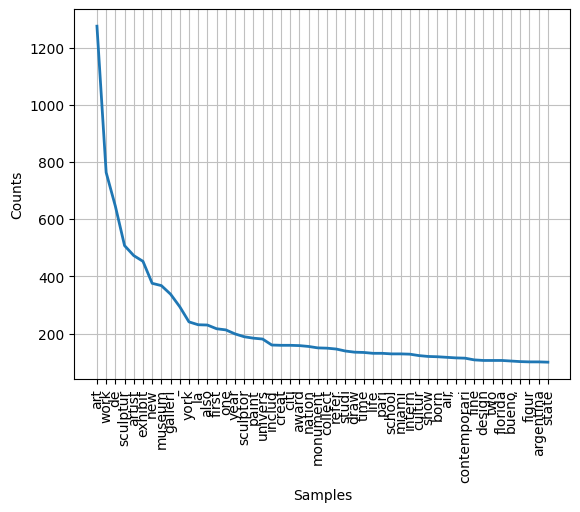

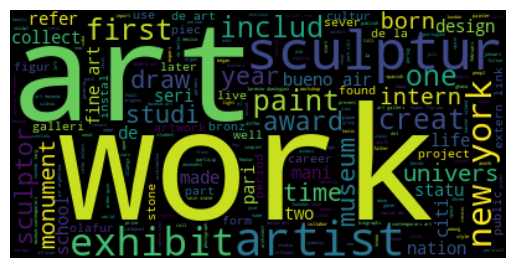

50 most frequent words and wordcloud for Journalists:


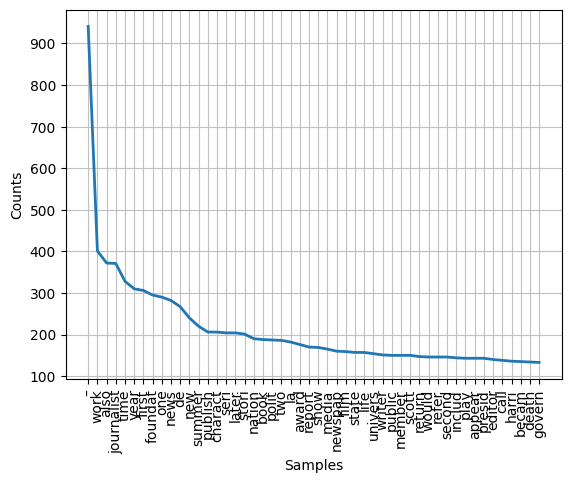

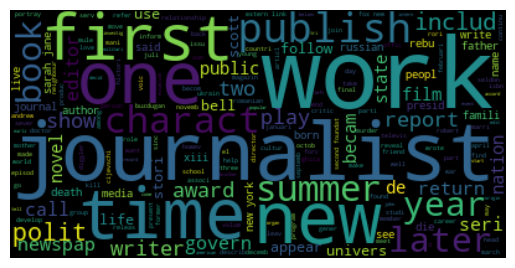

             min  max       mean
category                        
Journalists    3  492  52.876923
Sculptors      1  363  35.538462


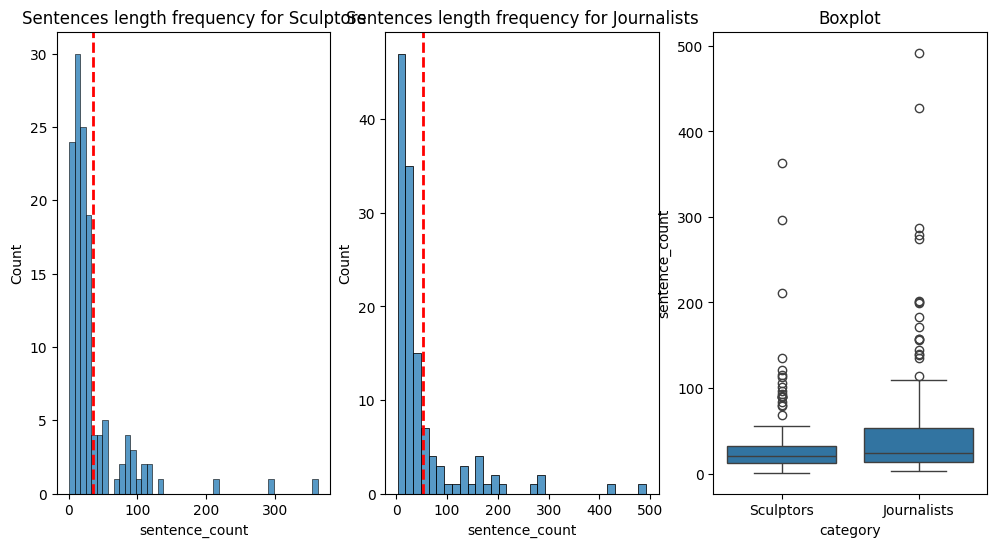

For the category Sculptors:
  there are 87831 bigrams in total and 52455 unique bigrams
  the minimum number of bigrams in a sentence is 0
  the maximum number of bigrams in a sentence is 362
  the average number of bigrams in a sentence is 19.01103896103896
For the category Journalists:
  there are 138083 bigrams in total and 81656 unique bigrams
  the minimum number of bigrams in a sentence is 0
  the maximum number of bigrams in a sentence is 569
  the average number of bigrams in a sentence is 20.087721850450976


In [7]:
#TEXT Data analysis
df = data_analysis(df)
sentences(df)
df = get_bigrams_list(df)
total_bigram_occ(df)


50 most frequent properties and wordcloud of properties for Journalists:


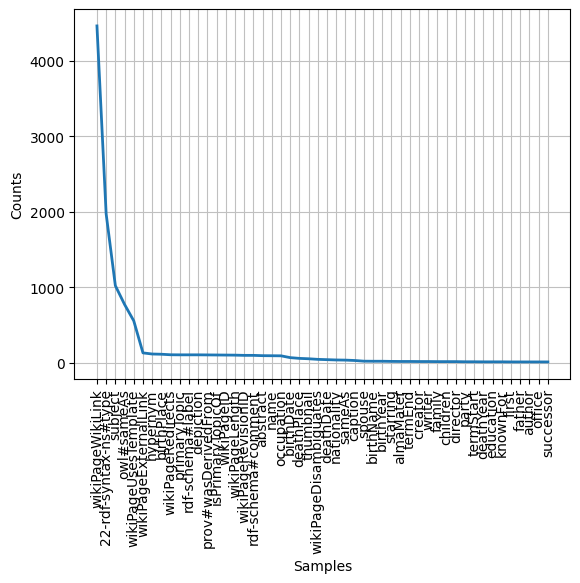

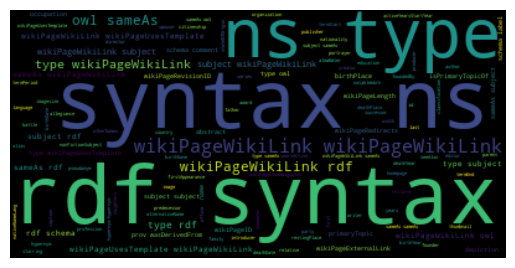

50 most frequent properties and wordcloud of properties for Sculptors:


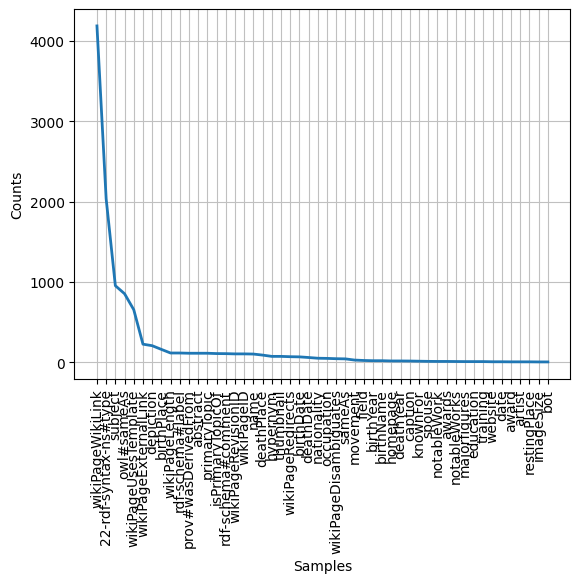

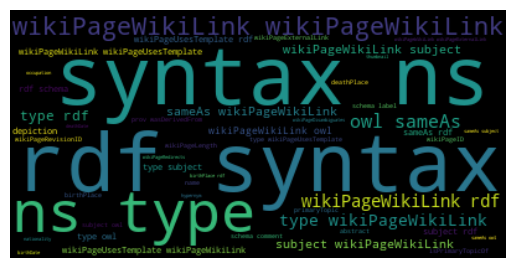

             min  max       mean
category                        
Journalists   11  100  87.423077
Sculptors     36  100  87.346154


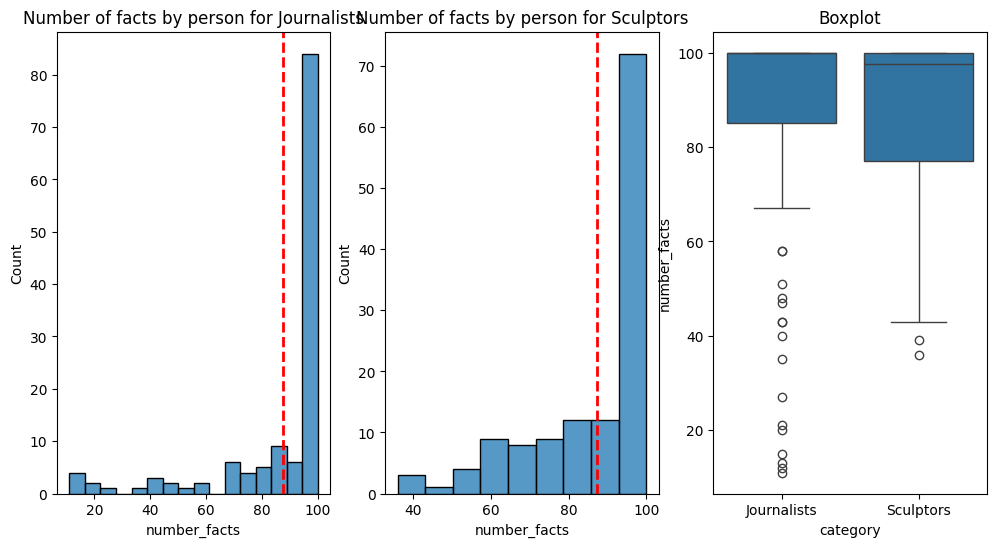

In [17]:
#GRAPH data analysis

knowledge_graph = retrieve_json('knowledge_graph.json')
most_freq_properties_and_cloud(knowledge_graph)
facts_graphs(knowledge_graph)
os.chdir('..')